In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

try:
    print("Loading Dataset...")
    df = yf.download("NVDA", start="2015-01-01")
    df.to_csv('../data/raw/nvidia_stock.csv')
    print("Downloaded Dataset")
    print(df.head(10))
    df.info()
    print(df.describe())
except FileNotFoundError as e:
    raise FileNotFoundError(e)
except Exception as e:
    print(e)

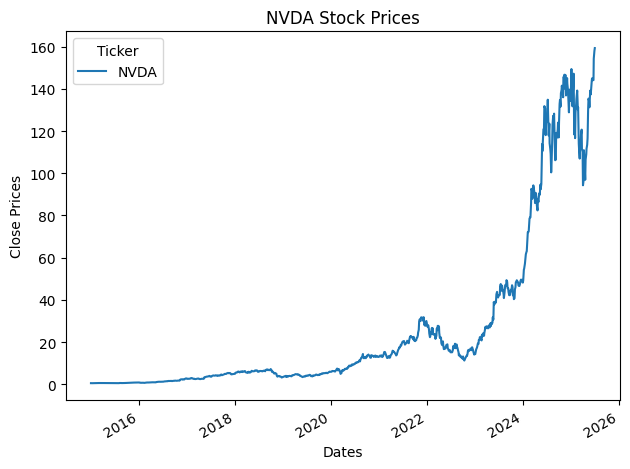

In [2]:
# Data Visualisation

import numpy as np

try:
    n_points = 1000
    indices = np.linspace(0, len(df) - 1, n_points, dtype=int)
    df_sampled = df.iloc[indices]
    df_sampled.plot(kind="line", y="Close")
    plt.ylabel("Close Prices")
    plt.xlabel("Dates")
    plt.title("NVDA Stock Prices")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(e)

In [3]:
# Data Preprocessing and Cleaning

# 1. Convert index to datetime
df.index = pd.to_datetime(df.index, dayfirst=True)

# 2. Rename All Columns
df.columns = ["Close", "High", "Low", "Open", "Volume"]

# 3. Remove duplicate dates
df = df[~df.index.duplicated(keep='first')]

# 4. Remove missing data
df = df.dropna(axis=0, how="any")

# 5. Filter out weekends
df = df[df.index.dayofweek < 5]

# 6. Sort index if needed
if not df.index.is_monotonic_increasing:
    df = df.sort_index()

# 7. Filter out skewed data
df = df[df.index >= "2020-01-01"]

# 8. Check DataFrame
df.info()
print(df.head())

# 9. Save Preprocessed
df.to_csv('../data/processed/nvidia_stock.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1383 entries, 2020-01-02 to 2025-07-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1383 non-null   float64
 1   High    1383 non-null   float64
 2   Low     1383 non-null   float64
 3   Open    1383 non-null   float64
 4   Volume  1383 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 64.8 KB
               Close      High       Low      Open     Volume
Date                                                         
2020-01-02  5.971747  5.971747  5.892343  5.942873  237536000
2020-01-03  5.876163  5.919972  5.827126  5.852018  205384000
2020-01-06  5.900805  5.906033  5.756683  5.782819  262636000
2020-01-07  5.972244  6.018045  5.884128  5.929182  314856000
2020-01-08  5.983446  6.024766  5.927938  5.968013  277108000


In [4]:
# Feature Engineering

# 1. Price-based Features
df['Return_Percentage'] = df['Close'].pct_change(1)
df['Volatility'] = df['Return_Percentage'].rolling(window=5).std()
df['Momentum'] = df['Close'].pct_change(5) # Tendency to persist in the same direction (Short Term Trends)
df['High_Low_Range'] = (df['High'] - df['Low']) / df['Close']

# 2. Volume-based Features
df['Volume_Momentum'] = df['Volume'] / df['Volume'].rolling(window=5).mean()
df['Price_Volume_Corr'] = df['Close'].rolling(window=5).corr(df['Volume'].shift(1)) # Relationship between Price/Volume in rolling window

# 3. Time-based Features
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

# 4. Lagged Features
df['Return_Percentage_lag1'] = df['Return_Percentage'].shift(1)
df['Return_Percentage_lag2'] = df['Return_Percentage'].shift(2)
df['Return_Percentage_lag5'] = df['Return_Percentage'].shift(5)
df['Volume_Change'] = df['Volume'].pct_change(1)
df['Volume_Change_lag1'] = df['Volume_Change'].shift(1)

# 5. Drop rows with NaN values created by rolling/lags
df = df.dropna()

# Correlation Analysis!

# 6. Check new features
display_cols = [
    'Close', 'Return_Percentage', 'Volatility', 'Momentum', 'High_Low_Range',
    'Volume_Momentum', 'Price_Volume_Corr', 'DayOfWeek', 'Month',
    'Return_Percentage_lag1', 'Return_Percentage_lag2', 'Return_Percentage_lag5',
    'Volume_Change', 'Volume_Change_lag1'
]
print(df[display_cols].head())

# 7. Save Preprocessed
df.to_csv('../data/processed/nvidia_stock.csv')

               Close  Return_Percentage  Volatility  Momentum  High_Low_Range  \
Date                                                                            
2020-01-10  6.081518           0.005349    0.004437  0.034947        0.019646   
2020-01-13  6.272190           0.031353    0.011421  0.062938        0.024764   
2020-01-14  6.155199          -0.018652    0.017976  0.030634        0.018319   
2020-01-15  6.112633          -0.006915    0.018908  0.021591        0.016940   
2020-01-16  6.196270           0.013683    0.019179  0.024319        0.009601   

            Volume_Momentum  Price_Volume_Corr  DayOfWeek  Month  \
Date                                                               
2020-01-10         1.109026           0.440105          4      1   
2020-01-13         1.078201           0.412144          0      1   
2020-01-14         1.175454           0.335660          1      1   
2020-01-15         0.869225           0.407575          2      1   
2020-01-16         0.921

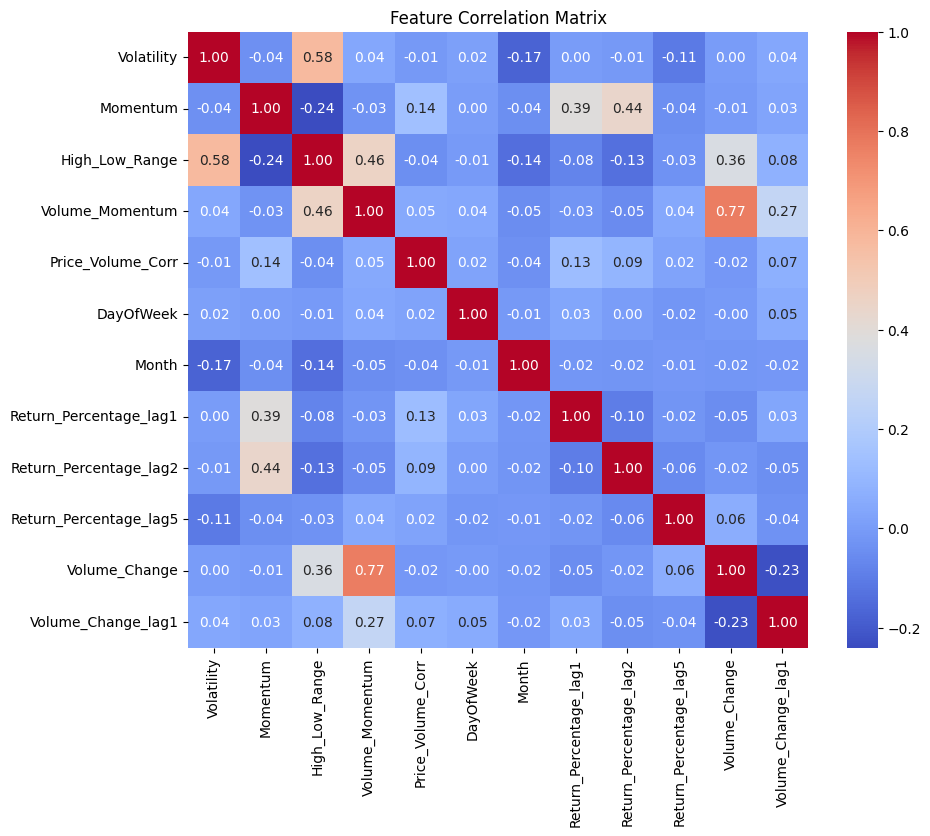

Highly correlated features to drop: []
Low-correlation features to drop: ['Price_Volume_Corr', 'Volume_Change_lag1']
Final features to use: ['Volatility', 'Momentum', 'High_Low_Range', 'Volume_Momentum', 'DayOfWeek', 'Month', 'Return_Percentage_lag1', 'Return_Percentage_lag2', 'Return_Percentage_lag5', 'Volume_Change']


In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. List of feature columns (exclude target and raw columns)
feature_cols = [
    'Volatility', 'Momentum', 'High_Low_Range',
    'Volume_Momentum', 'Price_Volume_Corr', 'DayOfWeek', 'Month',
    'Return_Percentage_lag1', 'Return_Percentage_lag2', 'Return_Percentage_lag5',
    'Volume_Change', 'Volume_Change_lag1'
]

# 2. Plot correlation matrix
corr_matrix = df[feature_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# 3. Remove highly correlated features (threshold = 0.9)
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("Highly correlated features to drop:", to_drop)

# 4. Remove features with low correlation to target (threshold = 0.01)
target_corr = df[feature_cols].corrwith(df['Target']).abs()
low_corr_features = target_corr[target_corr < 0.01].index.tolist()
print("Low-correlation features to drop:", low_corr_features)

# 5. Filtered feature set
filtered_features = [col for col in feature_cols if col not in to_drop + low_corr_features]
print("Final features to use:", filtered_features)

# 6. Use this for modeling
X_filtered = df[filtered_features]

First 5 rows of y:
Date
2020-01-10    0.031353
2020-01-13   -0.018652
2020-01-14   -0.006915
2020-01-15    0.013683
2020-01-16    0.001406
Name: Target, dtype: float64
First 5 rows of X_filtered:
            Volatility  Momentum  High_Low_Range  Volume_Momentum  DayOfWeek  \
Date                                                                           
2020-01-10    0.004437  0.034947        0.019646         1.109026          4   
2020-01-13    0.011421  0.062938        0.024764         1.078201          0   
2020-01-14    0.017976  0.030634        0.018319         1.175454          1   
2020-01-15    0.018908  0.021591        0.016940         0.869225          2   
2020-01-16    0.019179  0.024319        0.009601         0.921194          3   

            Month  Return_Percentage_lag1  Return_Percentage_lag2  \
Date                                                                
2020-01-10      1                0.010982                0.001876   
2020-01-13      1                0.0

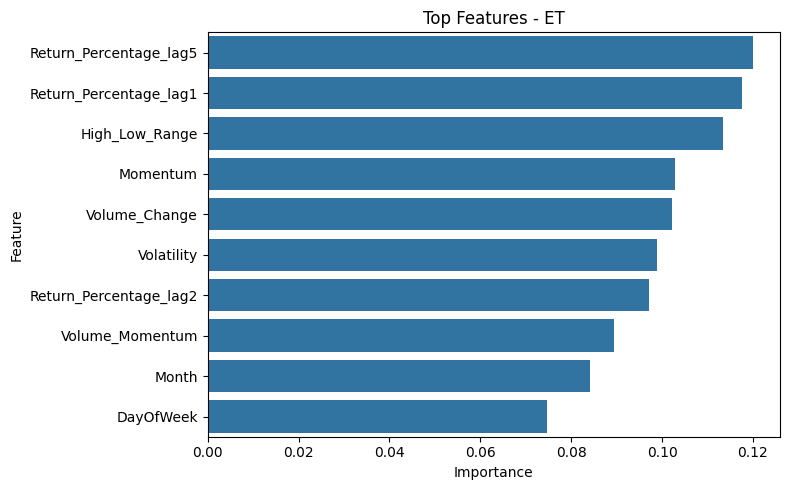

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- Use your filtered features from correlation analysis ---
filtered_features = [
    'Volatility', 'Momentum', 'High_Low_Range', 'Volume_Momentum',
    'DayOfWeek', 'Month', 'Return_Percentage_lag1', 'Return_Percentage_lag2',
    'Return_Percentage_lag5', 'Volume_Change'
]

df['Target'] = df['Return_Percentage'].shift(-1)
df = df.dropna()
X_filtered = df[filtered_features]
y = df['Target']

print("First 5 rows of y:")
print(y.head(5))
print("First 5 rows of X_filtered:")
print(X_filtered.head(5))

tscv = TimeSeriesSplit(n_splits=5)
models = {
    'RF': RandomForestRegressor(random_state=42, n_jobs=-1),
    'GB': GradientBoostingRegressor(random_state=42),
    'ET': ExtraTreesRegressor(random_state=42, n_jobs=-1),
    'XGB': XGBRegressor(random_state=42, n_jobs=-1),
    'LGBM': LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    'DT': DecisionTreeRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    neg_mse_scores = cross_val_score(
        model, X_filtered, y,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rmse_scores = np.sqrt(-neg_mse_scores)
    results[name] = rmse_scores.mean()
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['CV_RMSE']).sort_values('CV_RMSE')
print("\nCross-validated RMSE for each model:")
print(results_df)

best_name = results_df.index[0]
best_model = models[best_name].fit(X_filtered, y)
print(f"\nBest: {best_name} (RMSE: {results_df.iloc[0,0]:.6f})")

if hasattr(best_model, 'feature_importances_'):
    fi = pd.DataFrame({'Feature': X_filtered.columns, 'Importance': best_model.feature_importances_}).sort_values('Importance', ascending=False)
    print("\nTop 10 Feature Importances:")
    print(fi.head(10))
    plt.figure(figsize=(8, 5))
    sns.barplot(data=fi.head(10), x='Importance', y='Feature')
    plt.title(f'Top Features - {best_name}')
    plt.tight_layout()
    plt.show()

In [15]:
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# --- Use your filtered features from correlation analysis ---
filtered_features = [
    'Volatility', 'Momentum', 'High_Low_Range', 'Volume_Momentum',
    'DayOfWeek', 'Month', 'Return_Percentage_lag1', 'Return_Percentage_lag2',
    'Return_Percentage_lag5', 'Volume_Change'
]

# Make sure df['Target'] is already created and df is cleaned (dropna)
X_filtered = df[filtered_features]
y = df['Target']

# Initialize time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Store results
test_r2_scores = []
test_rmse_scores = []

for train_index, test_index in tscv.split(X_filtered):
    # Split data chronologically
    X_train, X_test = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train model
    model = ExtraTreesRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    # Evaluate on test fold
    preds = model.predict(X_test)
    test_r2_scores.append(r2_score(y_test, preds))
    test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))

# Print average performance across all folds
print(f"Average Test R²: {np.mean(test_r2_scores):.4f}")
print(f"Average Test RMSE: {np.mean(test_rmse_scores):.4f}")
print(f"\nRMSE per fold: {[f'{x:.4f}' for x in test_rmse_scores]}")
print(f"R² per fold: {[f'{x:.4f}' for x in test_r2_scores]}")

Average Test R²: -0.0814
Average Test RMSE: 0.0346

RMSE per fold: ['0.0271', '0.0423', '0.0366', '0.0298', '0.0371']
R² per fold: ['-0.1266', '-0.1488', '-0.0566', '-0.0462', '-0.0287']
